## 利用Pytorch实现线性回归

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集

In [2]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.1845, -0.9026]) 
label: tensor([4.8885])


features 中的每一行都包含一个二维数据样本，labels 中的每一行都包含一维标签值（一个标量）
通过生成第二个特征features[:, 1] 和labels 的散点图，可以直观观察到两者之间的线性关系。

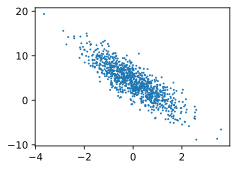

In [3]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集

训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个data_iter 函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成
大小为batch_size 的小批量。每个小批量包含一组特征和标签。

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

我们利用GPU 并行运算的优势，处理合理大小的“小批量”。每个样本都可以并行地进行模型计算，
且每个样本损失函数的梯度也可以被并行计算。GPU 可以在处理几百个样本时，所花费的时间不比处理一个样
本时多太多。

当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集：
```
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    .......
```

上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和数据流提供的数据。

### 初始化模型参数

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。在下面的代码中，我
们通过从均值为0、标准差为0.01 的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [5]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。每次更新都需要计
算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。

### 定义模型

接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。回想一下，要计算线性模型的输
出，我们只需计算输入特征𝑋 和模型权重𝑤 的矩阵-向量乘法后加上偏置𝑏。注意，上面的𝑋𝑤 是一个向量，而𝑏 是一个标量。

In [6]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

因为需要计算损失函数的梯度，所以我们应该先定义损失函数。线性回归利用平方损失函数。

In [7]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

小批量随机梯度下降法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损
失的方向更新我们的参数。下面的函数实现小批量随机梯度下降更新。该函数接受模型参数集合、学习速率和
批量大小作为输入。每一步更新的大小由学习速率lr 决定。因为我们计算的损失是一个批量样本的总和，所以
我们用批量大小（batch_size）来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [8]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。理解这段代码至关重
要，因为从事深度学习后，相同的训练过程几乎一遍又一遍地出现。在每次迭代中，我们读取一小批量训练样
本，并通过我们的模型来获得一组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们
调用优化算法sgd 来更新模型参数。概括一下，我们将执行以下循环：

在每个迭代周期（epoch）中，我们使用data_iter 函数遍历整个数据集，并将训练数据集中所有样本都使用
一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs 和学习率lr 都是超参数，分别设为3 和0.03。设置超参数很棘手，需要通过反复试验进行调整


In [9]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

print(f"w的估计误差: {true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差: {true_b - b}")

epoch 1, loss 0.047924
epoch 2, loss 0.000210
epoch 3, loss 0.000053
w的估计误差: tensor([ 0.0006, -0.0015], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

本节将介绍如何通过使用深度学习框架来简洁地实现线性回归模型。

### 生成数据集

In [10]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 读取数据集

我们可以调用框架中现有的API 来读取数据。我们将features 和labels 作为API 的参数传递，并通过数据迭
代器指定batch_size。此外，布尔值is_train 表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [11]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

使用data_iter 的方式与上节中使用data_iter 函数的方式相同。为了验证是否正常工作，让我们读取并打印
第一个小批量样本。这里我们使用iter 构造Python 迭代器，并使用next 从迭代器中获取第一项。

In [12]:
next(iter(data_iter))

[tensor([[-0.1976,  0.0946],
         [ 0.7733, -0.2332],
         [ 0.0765, -0.6067],
         [ 0.8509, -1.0243],
         [ 0.0312, -0.8008],
         [-0.8788,  0.7920],
         [ 0.0077,  0.8320],
         [-0.5769,  0.6537],
         [-2.1848,  0.3195],
         [-0.6000,  0.8390]]),
 tensor([[ 3.4892],
         [ 6.5525],
         [ 6.4142],
         [ 9.3757],
         [ 6.9957],
         [-0.2671],
         [ 1.3820],
         [ 0.8228],
         [-1.2666],
         [ 0.1597]])]

### 定义模型

对于标准深度学习模型，我们可以使用框架的预定义好的层。这使我们只需关注使用哪些层来构造模型，而
不必关注层的实现细节。我们首先定义一个模型变量net，它是一个Sequential 类的实例。Sequential 类将多个层串联在一起。当给定输入数据时，Sequential 实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，以此类推。在下面的例子中，我们的模型只包含一个层，因此实际上不需要Sequential。但是由于以后几乎所有的模型都是多层的，在这里使用Sequential 会让你熟悉“标准的流水线”。

回顾图1.1中的单层网络架构，这一单层被称为全连接层（fully-connected layer），因为它的每一个输入都通
过矩阵-向量乘法得到它的每个输出。

**在PyTorch 中，全连接层在Linear 类中定义。值得注意的是，我们将两个参数传递到nn.Linear 中。第一个
指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。**

In [13]:
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

### 初始化模型参数

在使用net 之前，我们需要初始化模型参数。如在线性回归模型中的权重和偏置。深度学习框架通常有预定
义的方法来初始化参数。在这里，我们指定每个权重参数应该从均值为0、标准差为0.01 的正态分布中随机采
样，偏置参数将初始化为零。

正如我们在构造nn.Linear 时指定输入和输出尺寸一样，现在我们能直接访问参数以设定它们的初始值。我们通过net[0] 选择网络中的第一个图层，然后使用weight.data 和bias.data 方法访问参数。我们还可以使用替换
方法normal_ 和fill_ 来重写参数值。

In [14]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)


tensor([0.])

### 定义损失函数

In [15]:
loss = nn.MSELoss()

### 定义优化算法

In [16]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练

通过深度学习框架的高级API 来实现我们的模型只需要相对较少的代码。我们不必单独分配参数、不必定
义我们的损失函数，也不必手动实现小批量随机梯度下降。当我们需要更复杂的模型时，高级API 的优势将大
大增加。当我们有了所有的基本组件，训练过程代码与我们从零开始实现时所做的非常相似。

回顾一下：在每个迭代周期里，我们将完整遍历一次数据集（train_data），不停地从中获取一个小批量的输
入和相应的标签。对于每一个小批量，我们会进行以下步骤:

通过调用net(X) 生成预测并计算损失l（前向传播）。

通过进行反向传播来计算梯度。

通过调用优化器来更新模型参数。

为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。

In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000284
epoch 2, loss 0.000107
epoch 3, loss 0.000107


下面我们比较生成数据集的真实参数和通过有限数据训练获得的模型参数。要访问参数，我们首先从net 访
问所需的层，然后读取该层的权重和偏置。正如在从零开始实现中一样，我们估计得到的参数与生成数据的真
实参数非常接近。

In [18]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([0.0007, 0.0004])
b的估计误差： tensor([0.0003])


## softmax回归

### 分类架构

我们从一个图像分类问题开始。假设每次输入是一个2 × 2 的灰度图像。我们可以用一个标量表示每个像素
值，每个图像对应四个特征𝑥1; 𝑥2; 𝑥3; 𝑥4。此外，假设每个图像属于类别“猫”“鸡”和“狗”中的一个。

接下来，我们要选择如何表示标签。我们有两个明显的选择：最直接的想法是选择𝑦 ∈ {1, 2, 3}，其中整数
分别代表 狗; 猫; 鸡。这是在计算机上存储此类信息的有效方法。如果类别间有一些自然顺序，比如说我们试图图预测{婴儿; 儿童; 青少年; 青年人; 中年人; 老年人}，那么将这个问题转变为回归问题，并且保留这种格式是有意义的。

但是一般的分类问题并不与类别之间的自然顺序有关。幸运的是，统计学家很早以前就发明了一种表示分类数据的简单方法：独热编码（one-hot encoding）。独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0。在我们的例子中，标签y 将是一个三维向量，其中(1; 0; 0) 对应“猫”、(0; 1; 0) 对应于“鸡”、(0; 0; 1) 对应于“狗”：

### 网络架构

为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型，每个类别对应一个输出。为了解决线性模型的分类问题，我们需要和输出一样多的仿射函数（affine function）。每个输出对应于它自己的仿射函数。
在我们的例子中，由于我们有4 个特征和3 个可能的输出类别，我们将需要12 个标量来表示权重（带下标的w），3 个标量来表示偏置（带下标的b）。下面我们为每个输入计算三个未规范化的预测（logit）：𝑜1、𝑜2 和𝑜3。

𝑜1 = 𝑥1𝑤11 + 𝑥2𝑤12 + 𝑥3𝑤13 + 𝑥4𝑤14 + 𝑏1; (1.3)

𝑜2 = 𝑥1𝑤21 + 𝑥2𝑤22 + 𝑥3𝑤23 + 𝑥4𝑤24 + 𝑏2; (1.4)

𝑜3 = 𝑥1𝑤31 + 𝑥2𝑤32 + 𝑥3𝑤33 + 𝑥4𝑤34 + 𝑏3 : (1.5)

为了更简洁地表达模型，我们仍然使用线性代数符号。通过向量形式表达为𝑜 = 𝑊𝑥 + 𝑏

由此，我们已经将所有权重放到一个3 × 4 矩阵中。对于给定数据样本的特征𝑥，我们的输出是由权重与输入特征进行矩阵-向量乘法再加上偏置𝑏 得到的。

### softmax运算

现在我们将优化参数以最大化观测数据的概率。为了得到预测结果，我们将设置一个阈值，如选择具有最
大概率的标签。我们希望模型的输出ˆ𝑦 𝑗 可以视为属于类j 的概率，然后选择具有最大输出值的类别𝑎𝑟𝑔𝑚𝑎𝑥 x 𝑗 𝑦 𝑗
作为我们的预测。例如，如果ˆ𝑦1、ˆ𝑦2 和ˆ𝑦3 分别为0.1、0.8 和0.1，那么我们预测的类别是2，在我们的例子中
代表“鸡”。

尽管softmax 是一个非线性函数，但softmax 回归的输出仍然由输入特征的仿射变换决定。因此，softmax 回
归是一个线性模型（linear model）。

## 图像分类数据集

MNIST 数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。我们将使用类似但更复
杂的Fashion-MNIST 数据集

### 读取数据

In [19]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [20]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0􀀀1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="../data", train=False, transform=trans, download=True)

Fashion-MNIST 由10 个类别的图像组成，每个类别由训练数据集（train dataset）中的6000 张图像和测试数据集
（test dataset）中的1000 张图像组成。因此，训练集和测试集分别包含60000 和10000 张图像。测试数据集不会
用于训练，只用于评估模型性能。

每个输入图像的高度和宽度均为28 像素。数据集由灰度图像组成，其通道数为1。为了简洁起见，本书将高度
h 像素、宽度w 像素图像的形状记为ℎ × 𝑤 或（h,w）。

In [21]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST 中包含的10 个类别，分别为t-shirt（T 恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、
coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在
数字标签索引及其文本名称之间进行转换。

In [22]:
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。

In [23]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
        # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

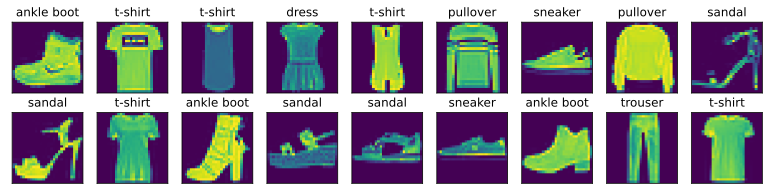

In [24]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建。回顾一
下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。通过内置数据迭代器，我们可
以随机打乱了所有样本，从而无偏见地读取小批量。

In [25]:
batch_size = 256
def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
num_workers=get_dataloader_workers())

看一下读取训练数据所需的时间。

In [52]:
print(f"一共有 {len(train_iter)} 个batch")
timer = d2l.Timer()
for X, y in train_iter:
    continue

f'{timer.stop():.2f} sec'

一共有 235 个batch


'3.54 sec'

### 整合所有组件

现在我们定义load_data_fashion_mnist 函数，用于获取和读取Fashion-MNIST 数据集。这个函数返回训练集
和验证集的数据迭代器。此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

In [27]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

下面，我们通过指定resize 参数来测试load_data_fashion_mnist 函数的图像大小调整功能。

In [28]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## softmax回归的从零开始实现

In [29]:
import torch
from IPython import display
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型参数

和之前线性回归的例子一样，这里的每个样本都将用固定长度的向量表示。原始数据集中的每个样本都是
28×28 的图像。本节将展平每个图像，把它们看作􀀀度为784 的向量。在后面的章节中，我们将讨论能够利用图
像空间结构的特征，但现在我们暂时只把每个像素位置看作一个特征。回想一下，在softmax 回归中，我们的输
出与类别一样多。因为我们的数据集有10 个类别，所以网络输出维度为10。因此，权重将构成一个784×10 的
矩阵，偏置将构成一个1×10 的行向量。与线性回归一样，我们将使用正态分布初始化我们的权重W，偏置初始
化为0。

In [30]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 定义softmax操作

在实现softmax 回归模型之前，我们简要回顾一下sum 运算符如何沿着张量中的特定维度工作，给定一个
矩阵X，我们可以对所有元素求和（默认情况下）。也可以只求同一个轴上的元素，即同一列（轴0）或同一行
（轴1）。如果X 是一个形状为(2, 3) 的张量，我们对列进行求和，则结果将是一个具有形状(3,) 的向量。当调用 sum 运算符时，我们可以指定保持在原始张量的轴数，而不折叠求和的维度。这将产生一个具有形状(1, 3) 的二维张量。

In [31]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

回想一下，实现softmax 由三个步骤组成：
1. 对每个项求幂（使用exp）；
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
3. 将每一行除以其规范化常数，确保结果的和为1。

In [32]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

正如上述代码，对于任何随机输入，我们将每个元素变成一个非负数。此外，依据概率原理，每行总和为1。

In [33]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)


(tensor([[0.0830, 0.2883, 0.3589, 0.0445, 0.2253],
         [0.0303, 0.0433, 0.5647, 0.0570, 0.3047]]),
 tensor([1.0000, 1.0000]))

### 定义模型

定义softmax 操作后，我们可以实现softmax 回归模型。下面的代码定义了输入如何通过网络映射到输出。
注意，将数据传递到模型之前，我们使用reshape 函数将每张原始图像展平为向量。

In [34]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数

接下来，我们实现交叉熵损失函数。这可能是深度学习中最常见的损失函数，因为目前分类问题的数量远
远超过回归问题的数量。回顾一下，交叉熵采用真实标签的预测概率的负对数似然。这里我们不使用Python 的
for 循环迭代预测（这往往是低效的），而是通过一个运算符选择所有元素。下面，我们创建一个数据样本y_hat，
其中包含2 个样本在3 个类别的预测概率，以及它们对应的标签y。有了y，我们知道在第一个样本中，第一类
是正确的预测；而在第二个样本中，第三类是正确的预测。然后使用y 作为y_hat 中概率的索引，我们选择第一
个样本中第一个类的概率和第二个样本中第三个类的概率。

In [35]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [36]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度

给定预测概率分布y_hat，当我们必须输出硬预测（hard prediction）时，我们通常选择预测概率最高的类。
许多应用都要求我们做出选择。如Gmail 必须将电子邮件分类为“Primary（主要邮件）”、“Social（社交邮
件）”“Updates（更新邮件）”或“Forums（论坛邮件）”。Gmail 做分类时可能在内部估计概率，但最终它必须在类中选择一个。

当预测与标签分类y 一致时，即是正确的。分类精度即正确预测数量与总预测数量之比。虽然直接优化精
度可能很困难（因为精度的计算不可导），但精度通常是我们最关心的性能衡量标准，我们在训练分类器时几乎
总会关注它。

为了计算精度，我们执行以下操作。首先，如果y_hat 是矩阵，那么假定第二个维度存储每个类的预测分数。
我们使用argmax 获得每行中最大元素的索引来获得预测类别。然后我们将预测类别与真实y 元素进行比较。由
于等式运算符“==”对数据类型很敏感，因此我们将y_hat 的数据类型转换为与y 的数据类型一致。结果是一个
包含0（错）和1（对）的张量。最后，我们求和会得到正确预测的数量。

In [37]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

我们将继续使用之前定义的变量y_hat 和y 分别作为预测的概率分布和标签。可以看到，第一个样本的预测类别
是2（该行的最大元素为0.6，索引为2），这与实际标签0 不一致。第二个样本的预测类别是2（该行的最大元
素为0.5，索引为2），这与实际标签2 一致。因此，这两个样本的分类精度率为0.5。

In [38]:
accuracy(y_hat, y) / len(y)

0.5

同样，对于任意数据迭代器data_iter 可访问的数据集，我们可以评估在任意模型net 的精度。

这里定义一个实用程序类Accumulator，用于对多个变量进行累加。在上面的evaluate_accuracy 函数中，我
们在Accumulator 实例中创建了2 个变量，分别用于存储正确预测的数量和预测的总数量。当我们遍历数据集
时，两者都将随着时间的推移而累加。

In [39]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

由于我们使用随机权重初始化net 模型，因此该模型的精度应接近于随机猜测。例如在有10 个类别情况下
的精度为0.1。

In [40]:
evaluate_accuracy(net, test_iter)

0.0726

### 训练

首先，我们定义一个函数来训练一个迭代周期。请注意，updater 是更新模型参数的常用函数，它接受批量
大小作为参数。它可以是d2l.sgd 函数，也可以是框架的内置优化函数。

In [41]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
    # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类Animator，它能够简化本书其余部
分的代码。

In [42]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
    ylim=None, xscale='linear', yscale='linear',
    fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
    figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

接下来我们实现一个训练函数，它会在train_iter 访问到的训练数据集上训练一个模型net。该训练函数将会运行
多个迭代周期（由num_epochs 指定）。在每个迭代周期结束时，利用test_iter 访问到的测试数据集对模型进行评
估。我们将利用Animator 类来可视化训练进度。

In [43]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save

    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

作为一个从零开始的实现，我们使用小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。

In [44]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

现在，我们训练模型10 个迭代周期。请注意，迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。通
过更改它们的值，我们可以提高模型的分类精度。

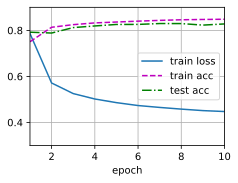

In [45]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

现在训练已经完成，我们的模型已经准备好对图像进行分类预测。给定一系列图像，我们将比较它们的实
际标签（文本输出的第一行）和模型预测（文本输出的第二行）。

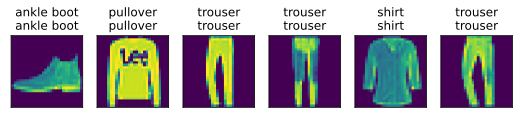

In [46]:
def predict_ch3(net, test_iter, n=6): #@save
    """预测标签（定义􀀀第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
    X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## Softmax回归的简洁实现

In [47]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 初始化模型参数

softmax 回归的输出层是一个全连接层。因此，为了实现我们的模型，我们只需在Sequential 中添加一个带
有10 个输出的全连接层。同样，在这里Sequential 并不是必要的，但它是实现深度模型的基础。我们仍然以均
值0 和标准差0.01 随机初始化权重。

In [48]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

### 损失函数

In [49]:
loss = nn.CrossEntropyLoss(reduction='none')

### 优化算法

在这里，我们使用学习率为0.1 的小批量随机梯度下降作为优化算法。这与我们在线性回归例子中的相同，
这说明了优化器的普适性。

In [50]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 训练

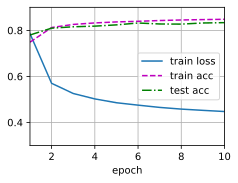

In [51]:
def main():
    num_epochs = 10
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


if __name__=="__main__":
    main()



注：在此过程中，遇到了如下报错：

> RuntimeError: DataLoader worker (pid(s) 2021200, 2015428, 202728) exited unexpectedly 

网上查到的原因是windows下不支持d2l中DataLoader的num_workers >0，即不能使用多线程读取数据。

但另外也在[Win10下num_works问题汇总 - 飞狗的文章 - 知乎](https://zhuanlan.zhihu.com/p/408877056)中看到了这种说法：
> 电脑默认情况下是没有给D盘分配虚拟内存的, 所以将Python装在D盘的朋友, 在跑程序时, 没有分配虚拟内存, 自然就遇到了上面的问题, 所以根本操作只要给D盘分配虚拟内存即可.(如果Python安装在C盘, 就更改C盘的虚拟内存的值, 调大点)

于是在高级系统设置-性能-虚拟内存中，取消“自动管理所有驱动器的分页文件大小”，选择“自定义大小”并为D盘设置10Gb的分页文件大小，成功解决问题。